In [1]:
# Import the libraries
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Load the household power consumption dataset
df = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt', sep=';',na_values = '?',
                 dtype = float ,low_memory=False,infer_datetime_format=True,parse_dates={'datetime':[0,1]},
                 index_col=['datetime'])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
# Ckeck the missing values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [4]:
# Shape of the dataset
r, c = df.shape
print('Number of rows:',r)
print('Number of columns:',c)

Number of rows: 2075259
Number of columns: 7


In [5]:
# Check the datatypes of cloumns
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [6]:
# Filling the missing values with the mean
df = df.fillna(df.mean())

In [7]:
# Check missing values filled or not
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [8]:
#daily resampling
daily_df = df.resample('D').sum()
print(daily_df.shape)

(1442, 7)


In [9]:
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [10]:
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000


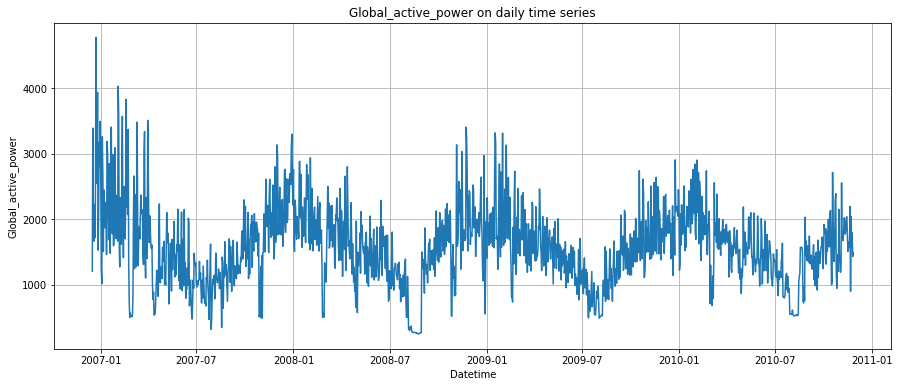

In [11]:
# Plot of Global_active_power on th daily time frame
plt.figure(figsize=(15,6))
plt.plot(daily_df.index, daily_df.Global_active_power)
plt.grid()
plt.title('Global_active_power on daily time series')
plt.xlabel("Datetime")
plt.ylabel("Global_active_power")
plt.show()

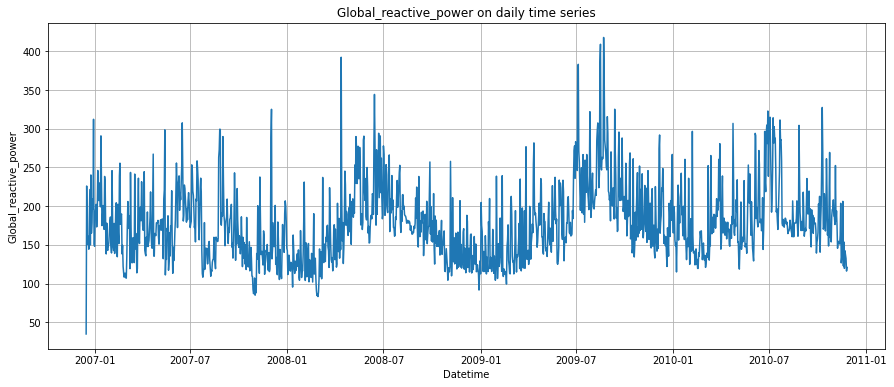

In [12]:
# Plot of Global_reactive_power on th daily time frame
plt.figure(figsize=(15,6))
plt.plot(daily_df.index, daily_df.Global_reactive_power)
plt.grid()
plt.title('Global_reactive_power on daily time series')
plt.xlabel("Datetime")
plt.ylabel("Global_reactive_power")
plt.show()

In [13]:
# Corr between Global_active_power and Global_reactive_power
from scipy.stats import pearsonr
pearsonr(df['Global_active_power'],df['Global_reactive_power'])

(0.24701705264406518, 0.0)

In [14]:
# Corr between Voltage and Global_intensity
from scipy.stats import pearsonr
pearsonr(df['Voltage'],df['Global_intensity'])

(-0.41136307176847087, 0.0)

In [15]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


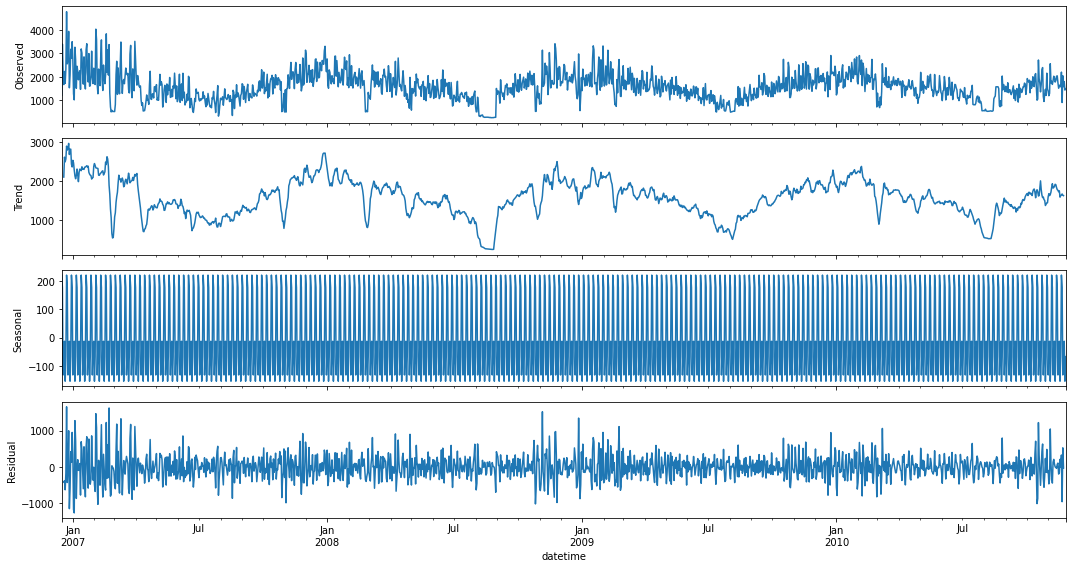

In [16]:
# Decompose daily time series
decompose_series = sm.tsa.seasonal_decompose(daily_df['Global_active_power'], model = 'additive')
decompose_series.plot()
plt.show()

In [17]:
# Perform the adfuller test to check whether Global_active_power series is stationary or non-stationary
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(daily_df['Global_active_power'])
print(f'ADF Statistics: {adf_result[0]}')
print(f'P-value: {adf_result[1]}')
print(f'No.lags used: {adf_result[2]}')
print(f'No. of obervation used: {adf_result[3]}')
print('Critical Vales:')
for k, v in adf_result[4].items():
    print(f'{k}:{v}:')

ADF Statistics: -3.731703845267444
P-value: 0.0036886778465985066
No.lags used: 22
No. of obervation used: 1419
Critical Vales:
1%:-3.434966750462565:
5%:-2.8635789736973725:
10%:-2.5678555388041384:


#### From the results obtained, *the p-value is greater than the critical value at a 5% level of significance* and, the ADF statistic is greater that any of the critical values obtain. *This confirms that the series is indeed stationary*.

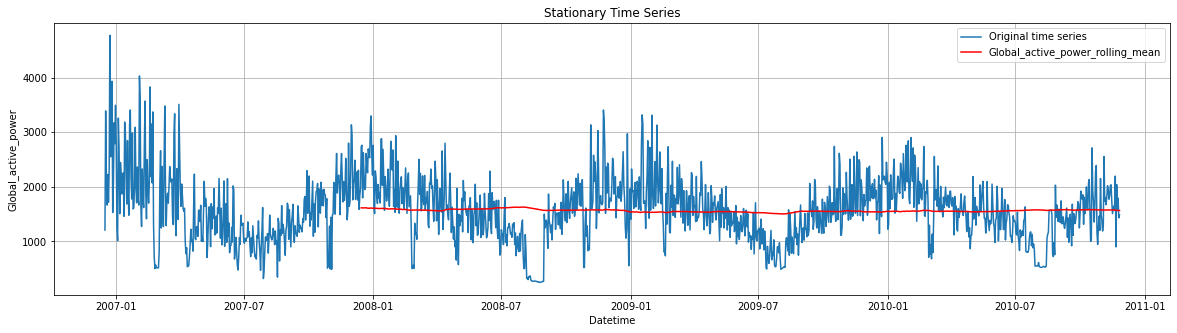

In [18]:
# Rolling mean
Global_active_power_rolling_mean = daily_df['Global_active_power'].rolling(365).mean()

# Visualise the plot
plt.figure(figsize=(20,5))
plt.title('Stationary Time Series')
plt.plot(daily_df.index, daily_df.Global_active_power, '-', label = 'Original time series')
plt.plot(Global_active_power_rolling_mean.index, Global_active_power_rolling_mean, color = 'red', label= 'Global_active_power_rolling_mean')
plt.ylabel('Global_active_power')
plt.xlabel('Datetime')
plt.legend(loc = 'best')
plt.grid()
plt.show()

# We perform univariate time series analysis 

In [19]:
from fbprophet import Prophet

In [20]:
# Now, we have to reset the datetime index into a column and assign it as a column in the new dataframe
daily_df.reset_index(inplace=True)
prophet_daily = daily_df[['datetime','Global_active_power']]

In [21]:
# Rename the columns
prophet_daily = prophet_daily.rename(columns = {'datetime': 'ds','Global_active_power': 'y'})
print(prophet_daily.shape)
prophet_daily.head()

(1442, 2)


,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [22]:
# Split the dateset into train set and test set
train_set, test_set  = prophet_daily.iloc[:1077,:], prophet_daily.iloc[1077:,:]
print(train_set.shape)
print(test_set.shape)

(1077, 2)
(365, 2)


In [23]:
# Fit the model
model = Prophet(daily_seasonality=True)
model.fit(train_set)

# Evaluate the model on test set
pred = model.predict(test_set)
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1229.032060,1530.235940,2643.574316,1229.032060,1229.032060,870.507696,870.507696,870.507696,351.928199,351.928199,351.928199,-64.130074,-64.130074,-64.130074,582.709572,582.709572,582.709572,0.0,0.0,0.0,2099.539756
1,2009-11-28,1229.156334,1858.617452,2941.494443,1229.156334,1229.156334,1173.710624,1173.710624,1173.710624,351.928199,351.928199,351.928199,245.827261,245.827261,245.827261,575.955164,575.955164,575.955164,0.0,0.0,0.0,2402.866957
2,2009-11-29,1229.280608,1838.360298,2945.449688,1229.280608,1229.280608,1147.683391,1147.683391,1147.683391,351.928199,351.928199,351.928199,228.529983,228.529983,228.529983,567.225208,567.225208,567.225208,0.0,0.0,0.0,2376.963999
3,2009-11-30,1229.404882,1417.808784,2536.953501,1229.404882,1229.404882,747.664390,747.664390,747.664390,351.928199,351.928199,351.928199,-161.290186,-161.290186,-161.290186,557.026377,557.026377,557.026377,0.0,0.0,0.0,1977.069272
4,2009-12-01,1229.529156,1555.663221,2646.690128,1229.529156,1229.529156,868.479335,868.479335,868.479335,351.928199,351.928199,351.928199,-29.334297,-29.334297,-29.334297,545.885433,545.885433,545.885433,0.0,0.0,0.0,2098.008491


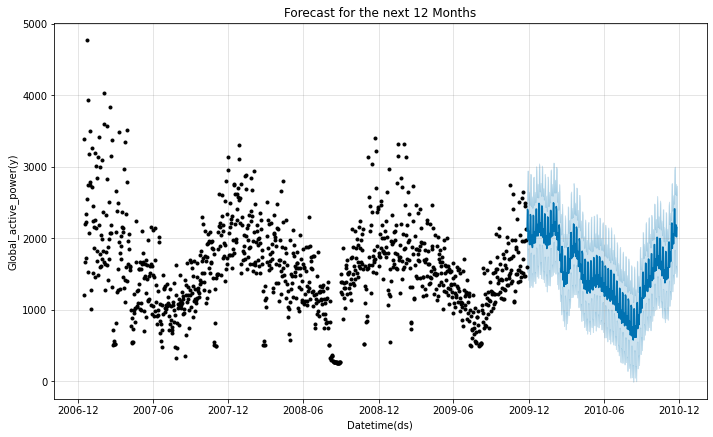

In [24]:
# Plot the model
model.plot(pred)
plt.title('Forecast for the next 12 Months')
plt.xlabel('Datetime(ds)')
plt.ylabel('Global_active_power(y)')
plt.show()

In [25]:
# Calculate the root mean square error
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(np.array(test_set['y']),np.array(pred['yhat'])))
print('RMSE: {}'.format(round(rmse,2)))

RMSE: 374.69


In [26]:
# MAPE
mape = np.mean(np.abs(np.array(test_set['y']) - np.array(pred.yhat[-365:]))/ np.array(test_set['y'])) *100
print("MAPE :",round(mape,2))

MAPE : 20.83


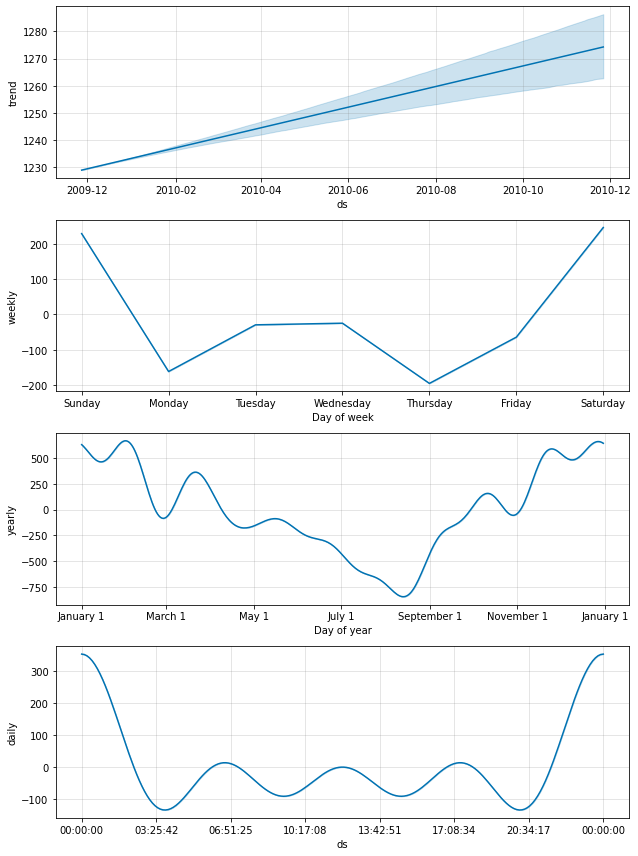

In [27]:
# Plot model components
model.plot_components(pred)
plt.show()

# Now onwards we perform multivariate time series analysis 

In [28]:
# reseting the index column of the daily_df
daily_df2 = daily_df
daily_df2.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [29]:
# Renaming the columns
daily_df2 = daily_df2.rename(columns = {'datetime':'ds','Global_active_power':'y','Global_reactive_power':'attr1',
                                                'Voltage':'attr2','Global_intensity':'attr3','Sub_metering_1':'attr4',
                                                'Sub_metering_2':'attr5','Sub_metering_3':'attr6'})
daily_df2.head()

,ds,y,attr1,attr2,attr3,attr4,attr5,attr6
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [30]:
# Split the dateset into train set and test set
train_set_2,test_set_2 = daily_df2.iloc[:1077,:], daily_df2.iloc[1077:,:]
print(train_set_2.shape)
print(test_set_2.shape)

(1077, 8)
(365, 8)


In [31]:
# Build the multivariate prophet model
model_2 = Prophet(daily_seasonality=True)
model_2.add_regressor('attr1')
model_2.add_regressor('attr2')
model_2.add_regressor('attr3')
model_2.add_regressor('attr4')
model_2.add_regressor('attr5')
model_2.add_regressor('attr6')

In [32]:
# Fitting the model
model_2.fit(train_set_2)

In [33]:
# Evaluate the model 2 on test_set_2 set
pred_2 = model_2.predict(test_set_2)
pred_2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,attr1,attr1_lower,attr1_upper,attr2,attr2_lower,attr2_upper,attr3,attr3_lower,attr3_upper,attr4,attr4_lower,attr4_upper,attr5,attr5_lower,attr5_upper,attr6,attr6_lower,attr6_upper,daily,daily_lower,daily_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2009-11-27,1310.007394,1365.292240,1397.172402,1310.007394,1310.007394,71.010214,71.010214,71.010214,7.550897,7.550897,7.550897,0.611613,0.611613,0.611613,-232.331927,-232.331927,-232.331927,2.206428,2.206428,2.206428,0.826488,0.826488,0.826488,3.862958,3.862958,3.862958,285.878204,285.878204,285.878204,-217.273544,-217.273544,-217.273544,-0.117448,-0.117448,-0.117448,2.523002,2.523002,2.523002,0.0,0.0,0.0,1381.017608
1,2009-11-28,1310.132803,1846.445842,1877.364917,1310.132803,1310.132803,551.699802,551.699802,551.699802,-8.897769,-8.897769,-8.897769,0.503214,0.503214,0.503214,263.410291,263.410291,263.410291,-2.031750,-2.031750,-2.031750,0.831774,0.831774,0.831774,7.747797,7.747797,7.747797,285.878204,285.878204,285.878204,261.563557,261.563557,261.563557,1.411473,1.411473,1.411473,2.846568,2.846568,2.846568,0.0,0.0,0.0,1861.832605
2,2009-11-29,1310.258212,1628.050153,1660.633687,1310.258212,1310.258212,333.869683,333.869683,333.869683,-2.800951,-2.800951,-2.800951,1.210648,1.210648,1.210648,47.464142,47.464142,47.464142,0.784870,0.784870,0.784870,-0.582363,-0.582363,-0.582363,-1.462280,-1.462280,-1.462280,285.878204,285.878204,285.878204,44.614067,44.614067,44.614067,0.172041,0.172041,0.172041,3.205371,3.205371,3.205371,0.0,0.0,0.0,1644.127895
3,2009-11-30,1310.383621,1727.041710,1758.898244,1310.383621,1310.383621,432.323517,432.323517,432.323517,3.922646,3.922646,3.922646,1.398875,1.398875,1.398875,131.755567,131.755567,131.755567,0.775596,0.775596,0.775596,0.844990,0.844990,0.844990,4.484306,4.484306,4.484306,285.878204,285.878204,285.878204,143.181981,143.181981,143.181981,-0.340705,-0.340705,-0.340705,3.604037,3.604037,3.604037,0.0,0.0,0.0,1742.707137
4,2009-12-01,1310.509029,1745.983846,1778.492719,1310.509029,1310.509029,451.938879,451.938879,451.938879,5.976453,5.976453,5.976453,0.931533,0.931533,0.931533,150.958193,150.958193,150.958193,2.206428,2.206428,2.206428,0.848691,0.848691,0.848691,2.764301,2.764301,2.764301,285.878204,285.878204,285.878204,163.685599,163.685599,163.685599,-1.671302,-1.671302,-1.671302,4.046378,4.046378,4.046378,0.0,0.0,0.0,1762.447909


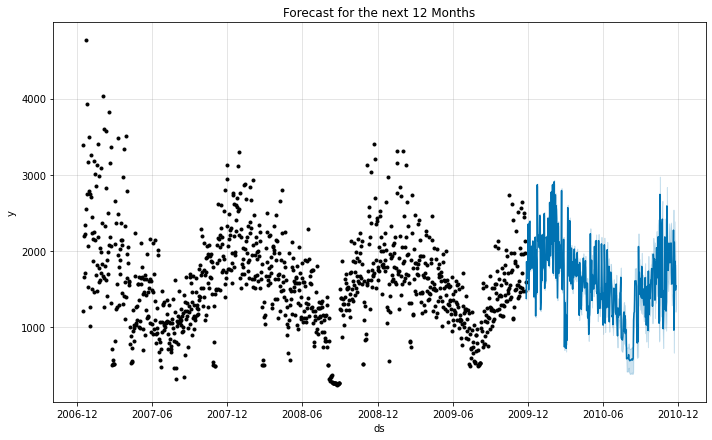

In [34]:
model_2.plot(pred_2)
plt.title('Forecast for the next 12 Months')
plt.show()

In [35]:
# Calculate the root mean square error
from sklearn import metrics
rmse = np.sqrt(metrics.mean_squared_error(np.array(test_set_2['y']),np.array(pred_2['yhat'])))
print('RMSE: {}'.format(round(rmse,2)))

RMSE: 40.48


In [36]:
# MAPE
mape = np.mean(np.abs(np.array(test_set_2['y']) - np.array(pred_2.yhat[-442:]))/ np.array(test_set_2['y'])) *100
print("MAPE :",round(mape,2))

MAPE : 2.73


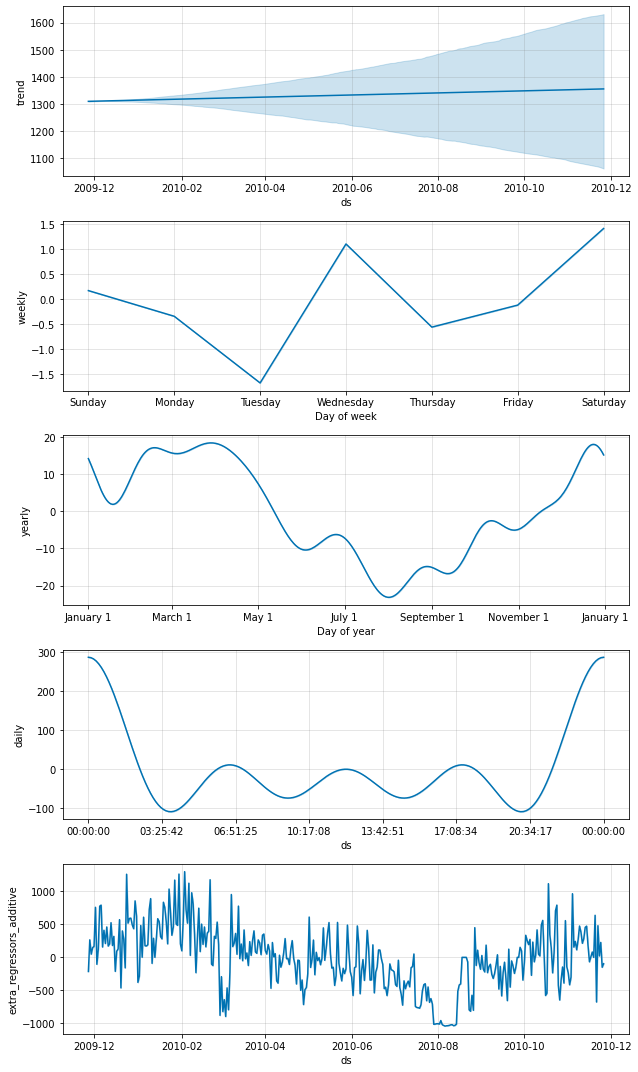

In [37]:
# Plot model 2 components
model_2.plot_components(pred_2)
plt.show()